<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Kaggle-Challenge/blob/master/Kaggle_Challenge_Sprint_Study_Guide3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os, sys
in_colab = 'google.colab' in sys.modules

# Pull files from Github repo
os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
!git pull origin master
    
# Install required python packages
!pip install -r requirements.txt
    
# Change into directory for module
os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.
  Using cached https://files.pythonhosted.org/packages/45/ad/24a16fa4ba612fb96a3c4bb115a5b9741483f53b66d3d3afd987f20fa227/phik-0.9.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/64/dc/6f35f114844fb12e38d60c4f3d2441a55baff7043ad4e013777dff55746c/pytest_pylint-0.14.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/e1/2f229554e5c273962fae8b286395d5bbcc7bef276d2b40e1bad954993db2/pytest-5.1.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ff/6f/faf9c586af455175b72186b9831cbf63e2222b17dde74d5eebff829e8ea5/pylint-2.4.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/89/479dc97e18549e21354893e4ee4ef36db1d237534982482c3681ee6e7b57/mccabe-0.6.1-py2.py3-none-any.whl
  Using

### Load and Split the Data - Train and Test

In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)
print(train.shape, val.shape, test.shape)

train.head()

(25475, 34) (6369, 34) (16973, 34)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
32201,1.0,0,2016-05-14 05:42:28,Upper East Prime location steps from all that ...,2nd Avenue,40.7813,-73.9494,2100,1751 2nd Avenue,high,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41782,1.0,1,2016-04-23 02:34:12,CooperCooper.com :: Web ID #156143; Access 100...,Chrystie Street,40.7233,-73.9915,4675,229 Chrystie Street,low,1,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
38111,1.0,2,2016-05-02 02:42:21,"Call, text or email me ASAP with the ID number...",E 3rd St,40.7216,-73.9808,3195,254 E 3rd St,low,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26998,1.0,2,2016-05-21 05:37:25,"ABSOLUTELY AMAZING Renovated 2 bedroom, very s...",E 77th St,40.7723,-73.9563,2950,253 E 77th St,medium,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2726,1.0,0,2016-04-28 17:18:47,Park Slope BROWnSTONE 2 Room Studio with Share...,136 Lincoln Place,40.6763,-73.9754,2800,135 Lincoln Place,low,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


### Baseline

In [9]:
print('Baseline - Mean of Price', train['price'].mean())

Baseline - Mean of Price 3580.408792934249


### Engineer Features

In [10]:
# Wrangle train & test sets in the same way
def engineer_features(df):
    
    # Avoid SettingWithCopyWarning
    df = df.copy()
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    
    # Extract number of days elapsed in year, and drop original date feature
    df['days'] = (df['created'] - pd.to_datetime('2016-01-01')).dt.days
    
    df = df.drop(columns='created')
    df = df.drop(columns='description')

    return df
  
train = engineer_features(train)
val = engineer_features(val)
test = engineer_features(test)

print(train.shape)
train.head()

(25475, 39)


,bathrooms,bedrooms,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,has_description,description_length,perk_count,cats_or_dogs,cats_and_dogs,rooms,days
32201,1.0,0,2nd Avenue,40.7813,-73.9494,2100,1751 2nd Avenue,high,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,599,3,False,False,1.0,134
41782,1.0,1,Chrystie Street,40.7233,-73.9915,4675,229 Chrystie Street,low,1,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True,915,7,True,True,2.0,113
38111,1.0,2,E 3rd St,40.7216,-73.9808,3195,254 E 3rd St,low,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,542,4,True,True,3.0,122
26998,1.0,2,E 77th St,40.7723,-73.9563,2950,253 E 77th St,medium,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,591,2,False,False,3.0,141
2726,1.0,0,136 Lincoln Place,40.6763,-73.9754,2800,135 Lincoln Place,low,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,True,1188,3,True,False,1.0,118


### Train, Validate, Test - 80/20

In [11]:
#train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)
print(train.shape, val.shape, test.shape)

(25475, 39) (6369, 39) (16973, 39)


### Cross-Validate

In [12]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

target = 'price'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val.columns.drop(target)
y_val = val[target]
X_test = test


pipeline = make_pipeline(
    #ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print('Mean of Scores: ', -scores.mean())
print('Standard Deviation of Scores: ', scores.std())
print('Absolute Scores:', abs(scores.std()/scores.mean()))

MAE for 3 folds: [412.16837219 408.79720129 411.15995068]
Mean of Scores:  410.70850805232976
Standard Deviation of Scores:  1.4128101196260034
Absolute Scores: 0.0034399338994116784


### Use Pipeline to Encode Categoricals and Fit a Random Forest

In [0]:
pipeline = make_pipeline(
    #ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
)

### Get Model's Validation Accuracy and Test Accuracy

In [14]:
pipeline.fit(X_train, y_train)

print ('Training Accuracy', pipeline.score(X_train, y_train))

pipeline.fit(X_val, y_val)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Training Accuracy 0.9884200196270854
Validation Accuracy 0.9919924634950542


In [18]:
#pipeline.fit(X_train, y_train)
#y_pred = pipeline.predict(X_val)
#print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.21133615952268803


### Confusion Matric with Binary Classification

In [26]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Out of 4 1's 3 are predicted correctly and out of 6 0's 4 are predicted correctly.
expected = [1,1,0,1,0,0,1,0,0,0]
predicted = [1,0,0,1,0,0,1,1,1,0]
cf =confusion_matrix(expected,predicted)
cf

array([[4, 2],
       [1, 3]])

In [27]:
# Crosstab the series
exp_series = pd.Series(expected)
pred_series = pd.Series(predicted)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,1,All
Actual,,,
0,4,2,6
1,1,3,4
All,5,5,10


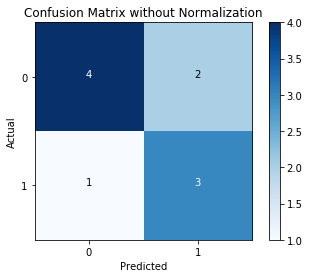

In [28]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(expected))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [29]:
from sklearn.metrics import classification_report
print(classification_report(exp_series, pred_series))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.60      0.75      0.67         4

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10

